In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instant-gratification/sample_submission.csv
/kaggle/input/instant-gratification/train.csv
/kaggle/input/instant-gratification/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
train = pd.read_csv("/kaggle/input/instant-gratification/train.csv")
test = pd.read_csv("/kaggle/input/instant-gratification/test.csv")
submission = pd.read_csv("/kaggle/input/instant-gratification/sample_submission.csv") 

# EDA (Exploratory Data Analysis)

## shape 확인

In [4]:
print(train.shape)
print(test.shape)
print(submission.shape)

(262144, 258)
(131072, 257)
(131072, 2)


## null 값 확인

In [12]:
# column에 따른 null 값 갯수
print(train.isnull().sum(), '\n')

# 전체 column에서 null 값 갯수
print(train.isnull().sum().sum())

id                                      0
muggy-smalt-axolotl-pembus              0
dorky-peach-sheepdog-ordinal            0
slimy-seashell-cassowary-goose          0
snazzy-harlequin-chicken-distraction    0
                                       ..
muggy-turquoise-donkey-important        0
blurry-buff-hyena-entropy               0
bluesy-chocolate-kudu-fepid             0
gamy-white-monster-expert               0
target                                  0
Length: 258, dtype: int64 

0


## 정답 레이블의 분포 확인
value_counts()

In [17]:
''' 
target column에서 정답의 분포를 확인할 수 있음
아래는 매우 고르게 정답이 분포되어 있기 때문에 따로 전처리과정을 거치지 않아도 됨.
'''
print(train["target"].value_counts(), '\n')

# column에 따른 data type 확인
print("column에 따른 data type 확인")
print(train.dtypes.value_counts())

target
1    131131
0    131013
Name: count, dtype: int64 

column에 따른 data type 확인
float64    255
int64        2
object       1
Name: count, dtype: int64


In [22]:
train.select_dtypes(include=["object", "int64"])

,id,wheezy-copper-turtle-magic,target
0,707b395ecdcbb4dc2eabea00e4d1b179,99,0
1,5880c03c6582a7b42248668e56b4bdec,52,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,230,1
3,e350f17a357f12a1941f0837afb7eb8d,78,0
4,a8f910ea6075b6376af079055965ff68,497,0
...,...,...,...
262139,b91d35316ec752958d33a10e612d9214,372,0
262140,8925b630059a8ad2c74e5f963e72d292,332,1
262141,701bb66c395a22e4e4fea479ed2c1431,448,0
262142,94a2f68c5432e7fe4f53a78c1a273a89,234,0


## 중복 확인하기

In [26]:
train_columns = [c for c in train.columns if c not in ["id", "target"]]

''' 
중복되지 않은 값을 확인하기
아래와 같이 25만개 이상 중복되지 않았다면 
해당 column은 id와 같이 고유값을 가지는 column일 것으로 추론가능함.
그렇다면 고유값을 가지는 column은 결국 해당 데이터의 경향성을 보기에 힘들기 때문에 삭제시키거나 
중요도를 낮게 설정하기 위해 진행함.
고유값의 갯수가 낮으면 보통 범주형 데이터라는 것을 유추가능
'''
print(train[train_columns].nunique())

muggy-smalt-axolotl-pembus              254322
dorky-peach-sheepdog-ordinal            254588
slimy-seashell-cassowary-goose          254356
snazzy-harlequin-chicken-distraction    254576
frumpy-smalt-mau-ordinal                254330
                                         ...  
jumpy-thistle-discus-sorted             254261
muggy-turquoise-donkey-important        254366
blurry-buff-hyena-entropy               254345
bluesy-chocolate-kudu-fepid             254329
gamy-white-monster-expert               254192
Length: 256, dtype: int64


In [30]:
nunique_values = train[train_columns].nunique() # nunique 한 결과물 들
print(nunique_values[nunique_values < 250000]) # nunique 한 결과물 중 25만보다 낮은것

wheezy-copper-turtle-magic    512
dtype: int64


In [35]:
print(train["wheezy-copper-turtle-magic"].value_counts().rename_axis(
    "wheezy-copper-turtle-magic"
).reset_index(name="counts"))

print("\n값 별로의 갯수 평균")
print(train["wheezy-copper-turtle-magic"].value_counts().mean())

     wheezy-copper-turtle-magic  counts
0                            51     570
1                           489     556
2                           298     554
3                           135     554
4                           245     553
..                          ...     ...
507                         277     476
508                         215     475
509                         108     472
510                          42     471
511                         185     442

[512 rows x 2 columns]

값 별로의 갯수 평균
512.0


# float 변수 확인하기 (범주형 아닌것으로 유추되는 데이터들)

In [40]:
train_columns = [c for c in train.columns if c not in ["id", "target", "wheezy-copper-turtle-magic"]]

# 선택한 열들의 dsecribe들을 생성함
describe_train = train[train_columns].describe().T.drop("count", axis=1)
# 생성된 배열에 색을 입혀 확인 쉽게 가능
cmap = sns.diverging_palette(5, 250, as_cmap=True)
# 그기기
describe_train.T.style.background_gradient(cmap, axis=1)

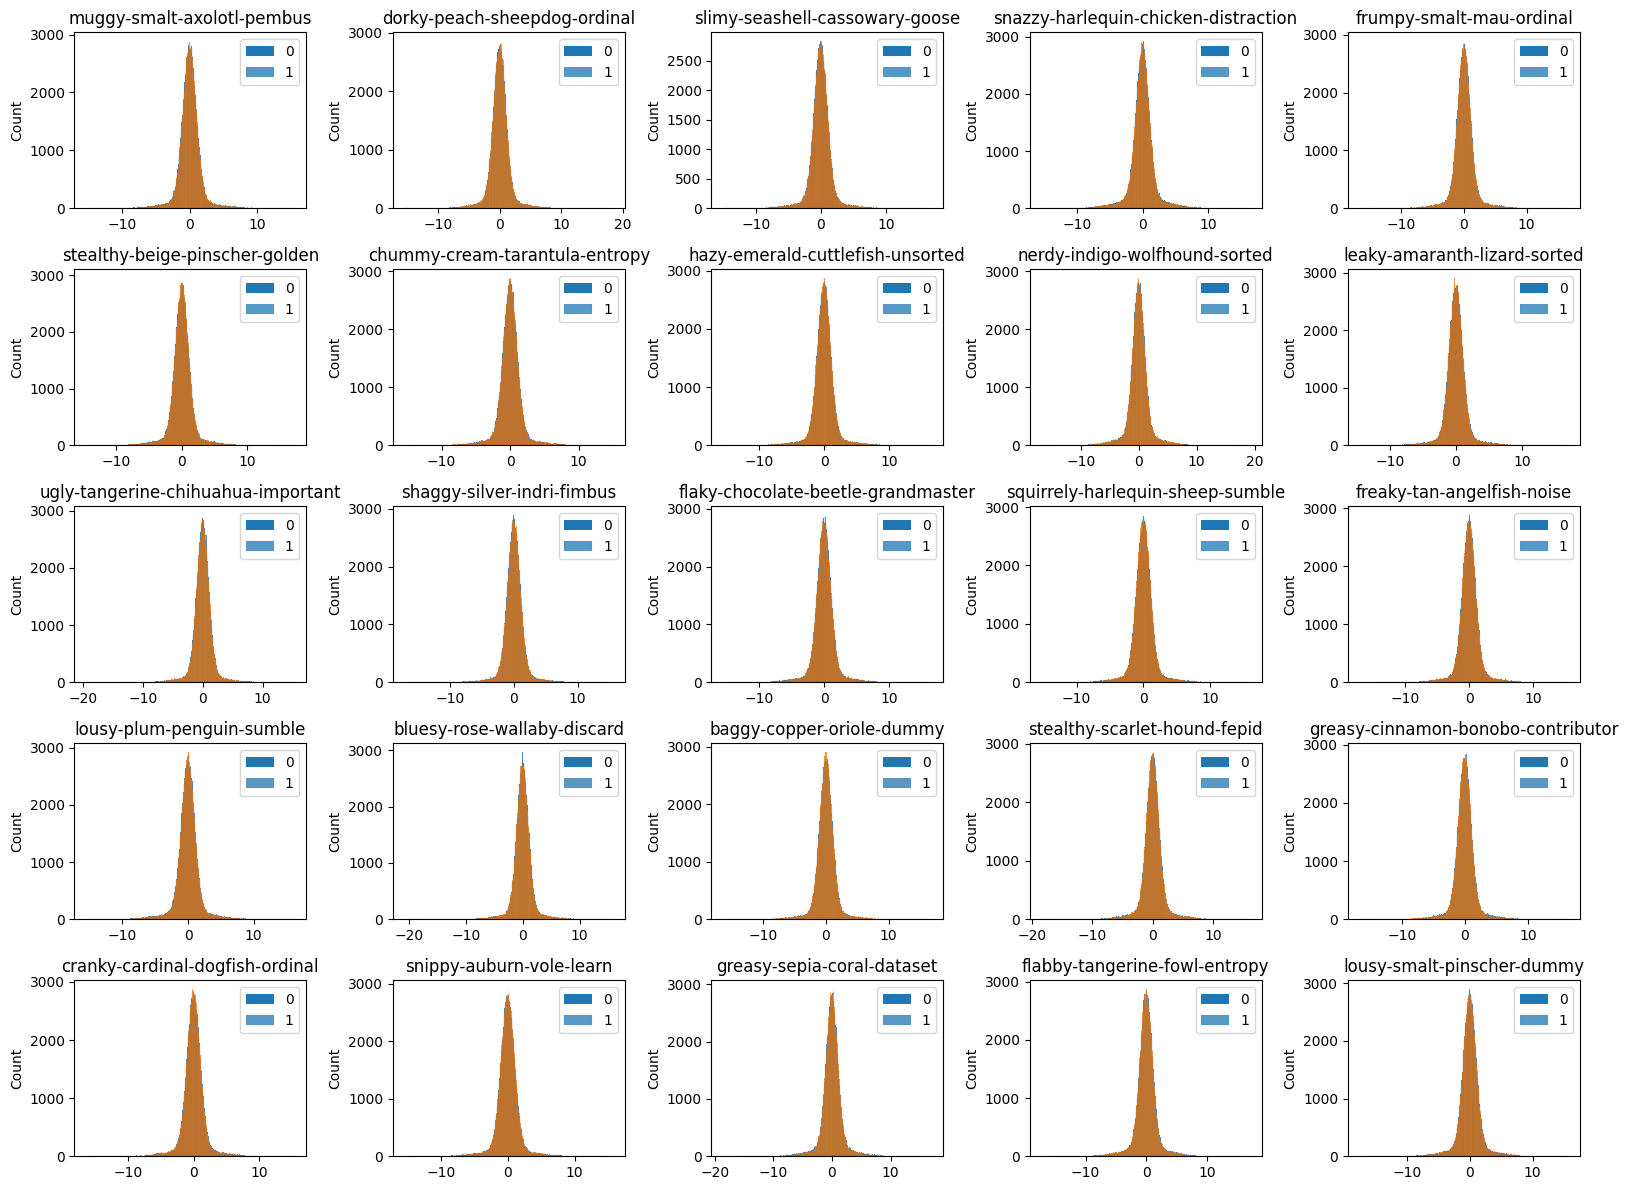

In [52]:
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning) # 오류 출력 안하기

# target값 (0,1)에 따라 히스토그램 그리며 분포가 달라지는 열 있는지 확인하기
train_columns = [c for c in train.columns if c not in ["id", "target"]]

train_0_df = train.loc[train["target"] == 0]
train_1_df = train.loc[train["target"] == 1]

# 자동으로 figure size 맞추기
# n_cols = 5
# n_rows = math.ceil(len(train_columns) / n_cols)
# plt.figure(figsize=(n_cols * 4, n_rows * 3))

plt.figure(figsize=(16,12))
for index, name in enumerate(train_columns[:25]): # 예시로 25개만 출력해봄
    plt.subplot(5, 5, index + 1)
    sns.histplot(train_0_df[name])
    sns.histplot(train_1_df[name])
    plt.title(name)
    plt.xlabel("")
    plt.legend(["0", "1"])

plt.tight_layout()
plt.show()

## cumsum().plot()
인덱스값에 따른 정답 분포를 확인할 수 있음

<Axes: >

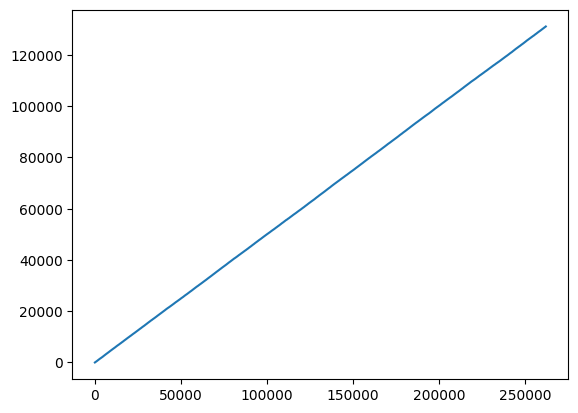

In [8]:
'''
* cumsum : 배열에서 주어진 축에 따라 누적되는 원소의 합을 계산
  [0 0 1 1 0 1 0] -> [0 0 1 2 2 3 3]
  아래는 y=x꼴로 나왔기에 0, 1이 조화롭게 섞여있는것을 확인할 수 있음
  만약 00000 11111 이런식이면 상수함수와 직선이 섞여있는 그림처럼 나왔을 것임
  잘 섞이지 않았을 경우 ID 같은 column도 학습에 사용할수도 있음
'''
train["target"].cumsum().plot()